# Assignment 4 - Computer-assisted drug discovery


#### The goal of this part of the assignment is to apply linear regression to the dataset in order to interpolate data


### Loading libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score, confusion_matrix,balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Loading the datasets

In [2]:
tested_data = pd.read_csv('tested_molecules_with_descriptors.csv')
tested_data.head()

,SMILES,PKM2_inhibition,ERK2_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C=C(C)c1nc(N)nc(N)n1,0,0,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,...,0,0,0,0,0,0,0,0,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,...,0,0,0,0,0,0,0,0,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,...,0,0,0,0,0,0,0,0,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,...,0,0,0,0,0,0,0,0,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,...,0,0,0,0,0,0,0,0,0,0


In [3]:
untested_data = pd.read_csv('untested_molecules_with_descriptors.csv')
untested_data.head()

,SMILES,PKM2_inhibition,ERK2_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C[C@@H](Sc1nc(=O)cc(N)[nH]1)C(=O)NC1CCCCC1,NaN,NaN,12.102478,12.102478,0.021321,-0.399409,0.573774,17.650000,296.396,...,1,0,0,0,0,0,0,0,0,0
1,O=C(CCN1C(=O)COc2ccccc21)NCc1cccs1,NaN,NaN,11.985063,11.985063,0.021654,-0.120596,0.919617,13.454545,316.382,...,0,0,0,0,0,0,0,1,0,0
2,Cn1nnnc1SCC(=O)N1CC[NH+](Cc2ccccc2)CC1,NaN,NaN,12.287562,12.287562,0.163668,0.163668,0.727985,15.782609,333.441,...,1,0,0,0,1,0,0,0,0,0
3,CCOC(=O)CCP(=O)([O-])[C@@H](O)c1ccc(OC)cc1,NaN,NaN,11.932898,11.932898,0.197446,-4.142696,0.601737,12.800000,301.255,...,0,0,0,0,0,0,0,0,0,0
4,C=CCNC(=O)c1cc(-c2ccccc2O)on1,NaN,NaN,11.589256,11.589256,0.075648,-0.346925,0.806028,10.000000,244.250,...,0,0,0,0,0,0,0,0,0,0


### Step 1: performing the PCA for testend and untested molecules

In [4]:
#tested molecules
# Separate the molecular descriptors from the inhibition labels and SMILES
df_descriptors = tested_data[['PKM2_inhibition', 'ERK2_inhibition']]
df_tested_data= tested_data.drop(columns=['PKM2_inhibition', 'ERK2_inhibition', 'SMILES'])
df_descriptors.head()

,PKM2_inhibition,ERK2_inhibition
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [5]:
#untested molecules --> shows NaN obviously 
# Separate the molecular descriptors from the inhibition labels and SMILES
df_descriptors2 = untested_data[['PKM2_inhibition', 'ERK2_inhibition']]
df_untested_data= untested_data.drop(columns=['PKM2_inhibition', 'ERK2_inhibition', 'SMILES'])
df_descriptors2.head()

,PKM2_inhibition,ERK2_inhibition
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [6]:
#tested data
#Removing the values with 0 variance
selector = VarianceThreshold(threshold=0.0)
transformed_data = selector.fit_transform(df_tested_data)
kept_columns = df_tested_data.columns[selector.get_support(indices=True)]
df_data = df_tested_data[kept_columns]
df_data.head()


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,58,...,0,0,0,0,0,0,0,0,0,0
1,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,88,...,0,0,0,0,0,0,0,0,0,0
2,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,84,...,0,0,0,0,0,0,0,0,0,0
3,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,88,...,0,0,0,0,0,0,0,0,0,0
4,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,80,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#untested data
#Removing the values with 0 variance
selector = VarianceThreshold(threshold=0.0)
transformed_data = selector.fit_transform(df_untested_data)
kept_columns = df_untested_data.columns[selector.get_support(indices=True)]
df_data2 = df_untested_data[kept_columns]
df_data2.head()


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.102478,12.102478,0.021321,-0.399409,0.573774,17.650000,296.396,276.236,296.130697,110,...,0,1,0,0,0,0,0,0,0,0
1,11.985063,11.985063,0.021654,-0.120596,0.919617,13.454545,316.382,300.254,316.088163,114,...,0,0,0,0,0,0,0,1,0,0
2,12.287562,12.287562,0.163668,0.163668,0.727985,15.782609,333.441,312.273,333.149207,122,...,1,1,0,0,0,1,0,0,0,0
3,11.932898,11.932898,0.197446,-4.142696,0.601737,12.800000,301.255,283.111,301.084649,112,...,0,0,0,0,0,0,0,0,0,0
4,11.589256,11.589256,0.075648,-0.346925,0.806028,10.000000,244.250,232.154,244.084792,92,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#tested data
# use the minmax scaler to scale the data (dataset has no normal distribution --> code tim en jelle)
mscaler = MinMaxScaler()
for x in df_data:
    mscaled_data = mscaler.fit_transform(df_data)
mscaled_data

array([[0.17315656, 0.17315656, 0.10944618, ..., 0.        , 0.        ,
        0.        ],
       [0.68156528, 0.68156528, 0.20428624, ..., 0.        , 0.        ,
        0.        ],
       [0.66884466, 0.66884466, 0.04479121, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.62499629, 0.62499629, 0.22641213, ..., 0.        , 0.        ,
        0.        ],
       [0.13011267, 0.13011267, 0.89246706, ..., 0.        , 0.        ,
        0.        ],
       [0.12680157, 0.12680157, 0.6010046 , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
#untested data
# use the minmax scaler to scale the data (dataset has no normal distribution --> code tim en jelle)
for x in df_data2:
    mscaled_data2 = mscaler.fit_transform(df_data2)
mscaled_data2

array([[0.7553011 , 0.7553011 , 0.01773531, ..., 0.        , 0.        ,
        0.        ],
       [0.74624127, 0.74624127, 0.01801314, ..., 0.5       , 0.        ,
        0.        ],
       [0.76958218, 0.76958218, 0.13627166, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.23857215, 0.23857215, 0.25765569, ..., 0.        , 0.        ,
        0.        ],
       [0.80253256, 0.80253256, 0.0903034 , ..., 0.        , 0.        ,
        0.        ],
       [0.72546542, 0.72546542, 0.02124239, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
# tested data
# Perform PCA
pca = PCA()
df_pca = pca.fit_transform(mscaled_data)

In [11]:
# untested data
# Perform PCA
pca2 = PCA()
df_pca2 = pca2.fit_transform(mscaled_data2)

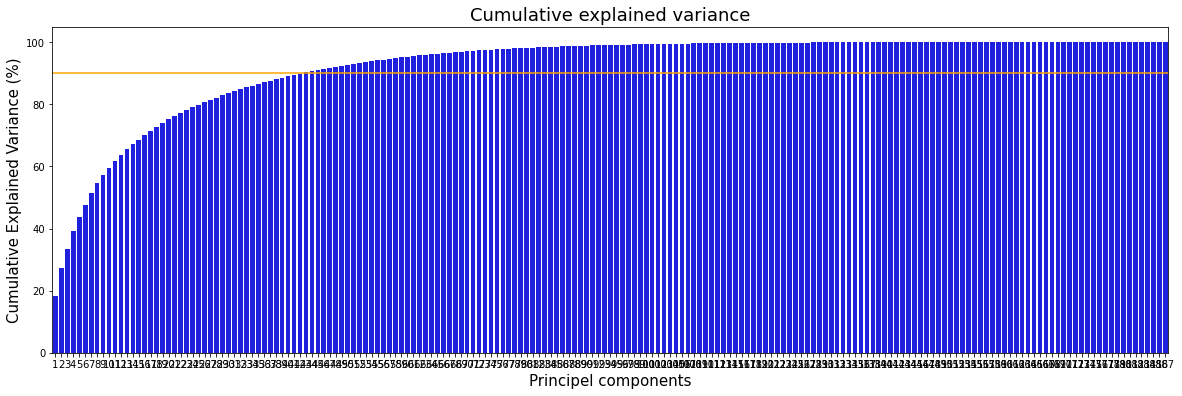

In [12]:
#tested data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio) * 100

plt.figure(figsize=(20, 6))
sns.barplot(x=np.arange(1, len(cumulative_variance) + 1), y=cumulative_variance, color = 'blue')
plt.axhline(y=90, color='orange', linestyle='-')
plt.xlabel('Principel components', size = 15)
plt.ylabel('Cumulative Explained Variance (%)', size = 15)
plt.title('Cumulative explained variance', size = 18);

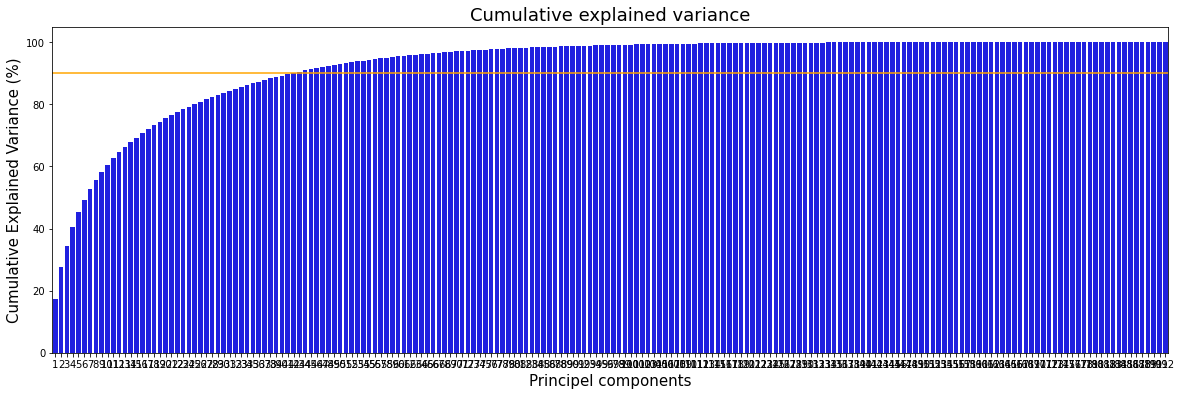

In [13]:
#untested data
explained_variance_ratio = pca2.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio) * 100

plt.figure(figsize=(20, 6))
sns.barplot(x=np.arange(1, len(cumulative_variance) + 1), y=cumulative_variance, color = 'blue')
plt.axhline(y=90, color='orange', linestyle='-')
plt.xlabel('Principel components', size = 15)
plt.ylabel('Cumulative Explained Variance (%)', size = 15)
plt.title('Cumulative explained variance', size = 18);

In [14]:
#tested data
# amount of variables that capture 90% of the dataset
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.90) + 1
num_components

43

In [15]:
# untested data
# amount of variables that capture 90% of the dataset
cum_variance = np.cumsum(pca2.explained_variance_ratio_)
nr_components = np.argmax(cum_variance >= 0.90) + 1
nr_components

42

In [17]:
#tested data
pca = PCA(n_components=42) #lowered to 42 as they need the same amount of principal components
df_pca = pca.fit_transform(mscaled_data)
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(nr_components)])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,-2.309637,0.110012,-0.167813,0.415622,-0.708684,-0.228995,0.489278,0.502501,0.275602,0.162118,...,-0.142187,0.124856,0.088242,0.192542,-0.065759,0.052159,0.334607,-0.019519,0.122740,0.226370
1,-1.480759,0.071782,-0.362191,0.134438,0.060656,0.418068,-0.170566,-0.134418,-0.272864,0.036359,...,0.031969,0.197216,0.177308,0.111042,0.035378,-0.014058,0.197017,-0.103203,0.013976,-0.106985
2,-1.339915,-0.732580,-0.292050,-0.000753,-0.335781,-0.633835,0.249659,-0.172005,0.593964,-0.902177,...,-0.249200,-0.037659,0.195190,0.209264,-0.093051,0.054584,0.099835,0.082058,0.288939,-0.153770
3,-1.308999,0.064898,-0.297212,0.293516,0.022695,-0.197050,-0.325009,0.276726,-0.198567,-0.193867,...,-0.227046,0.069297,0.397657,0.057815,0.126980,0.120893,0.097797,-0.115002,0.022821,-0.172196
4,-1.689393,0.044651,-0.294213,-0.450916,-0.044919,-0.209564,-0.037220,0.018401,-0.407771,-0.437465,...,0.080321,-0.150986,0.158170,0.159374,0.162417,-0.032207,0.065943,-0.032440,0.358183,-0.021006


In [18]:
#untested data
pca2 = PCA(n_components=42) # to fit model
df_pca2 = pca2.fit_transform(mscaled_data2)
df_pca2 = pd.DataFrame(df_pca2, columns=[f'PC{i+1}' for i in range(nr_components)])
df_pca2.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,-0.506291,-0.530563,0.604416,-0.375360,-0.384172,-0.381090,-0.576531,0.360551,-0.254950,0.018190,...,-0.067398,-0.116669,0.092564,0.031242,0.042855,-0.102173,-0.189849,-0.147085,-0.084886,0.055542
1,-0.324602,-0.088020,-0.289666,0.023636,-0.041126,-0.276859,0.025459,0.244078,0.383513,-0.082557,...,-0.092269,0.069829,-0.013593,0.214269,0.201940,-0.126850,-0.032584,0.097457,-0.108564,0.027200
2,0.070954,-0.035323,0.915585,0.228246,-0.259784,0.486855,-0.443836,-0.094016,0.186653,-0.510461,...,0.048462,0.035440,-0.002900,0.281754,0.016380,-0.100781,0.011332,-0.123254,0.044026,0.039103
3,-0.385204,-0.623824,-0.619721,-0.574828,-0.333740,0.241000,0.349741,0.182030,-0.413507,0.195036,...,-0.142018,0.165991,-0.228789,0.150952,0.056371,0.270031,0.045452,-0.111458,-0.026318,0.055913
4,-1.020383,0.200368,-0.385310,-0.104749,-0.377864,-0.216932,-0.059877,-0.081998,-0.095449,0.093743,...,-0.072322,-0.152616,-0.218413,0.192905,0.012623,0.129879,0.149547,0.137915,0.029705,0.049721


### Step 2: Linear Regression

##### Performing linear regression on the test data, this will later serve as our model to predict the untested data

In [30]:
#splitting the tested data
X_tested = df_pca.iloc[:, 3:]  # Features (from the 4th column onward)
y_pkm2_tested = df_pca.iloc[:, 1]  # PKM2 target (2nd column)
y_erk2_tested = df_pca.iloc[:, 2]  # ERK2 target (3rd column)

In [31]:
# Split the untested dataset into features
X_untested = df_pca2.iloc[:, 3:]  # Features (from the 4th column onward)

#### training the data

In [37]:
# Train linear regression model for PKM2
model_pkm2 = LinearRegression()
model_pkm2.fit(X_tested, y_pkm2_tested)

# Train linear regression model for ERK2
model_erk2 = LinearRegression()
model_erk2.fit(X_tested, y_erk2_tested);

#### Testing the PKM2 inhibition

In [22]:
# Predict on the tested dataset
y_pkm2_pred_tested = model_pkm2.predict(X_tested)
y_erk2_pred_tested = model_erk2.predict(X_tested)

# Binarize the predictions: Convert regression outputs to binary (0 or 1)
y_pkm2_pred_tested_binary = np.where(y_pkm2_pred_tested >= 0.5, 1, 0)
y_erk2_pred_tested_binary = np.where(y_erk2_pred_tested >= 0.5, 1, 0)

# Ensure the target values are also binary
y_pkm2_tested_binary = np.where(y_pkm2_tested >= 0.5, 1, 0)
y_erk2_tested_binary = np.where(y_erk2_tested >= 0.5, 1, 0)

# Evaluate the PKM2 model
accuracy_pkm2 = accuracy_score(y_pkm2_tested_binary, y_pkm2_pred_tested_binary)
balanced_accuracy_pkm2 = balanced_accuracy_score(y_pkm2_tested_binary, y_pkm2_pred_tested_binary)

print(f'PKM2 Model Accuracy: {accuracy_pkm2}')
print(f'PKM2 Model Balanced Accuracy: {balanced_accuracy_pkm2}')
print(confusion_matrix(y_pkm2_tested_binary, y_pkm2_pred_tested_binary))
print(classification_report(y_pkm2_tested_binary, y_pkm2_pred_tested_binary))

# Evaluate the ERK2 model
accuracy_erk2 = accuracy_score(y_erk2_tested_binary, y_erk2_pred_tested_binary)
balanced_accuracy_erk2 = balanced_accuracy_score(y_erk2_tested_binary, y_erk2_pred_tested_binary)

print(f'ERK2 Model Accuracy: {accuracy_erk2}')
print(f'ERK2 Model Balanced Accuracy: {balanced_accuracy_erk2}')
print(confusion_matrix(y_erk2_tested_binary, y_erk2_pred_tested_binary))
print(classification_report(y_erk2_tested_binary, y_erk2_pred_tested_binary));



PKM2 Model Accuracy: 0.7840501792114696
PKM2 Model Balanced Accuracy: 0.5
[[875   0]
 [241   0]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       875
           1       0.00      0.00      0.00       241

    accuracy                           0.78      1116
   macro avg       0.39      0.50      0.44      1116
weighted avg       0.61      0.78      0.69      1116

ERK2 Model Accuracy: 0.8216845878136201
ERK2 Model Balanced Accuracy: 0.5
[[917   0]
 [199   0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       917
           1       0.00      0.00      0.00       199

    accuracy                           0.82      1116
   macro avg       0.41      0.50      0.45      1116
weighted avg       0.68      0.82      0.74      1116



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### Step 3. Predicting for the untested data

In [23]:
# Predict on the untested dataset
pkm2_predictions_untested = model_pkm2.predict(X_untested)
erk2_predictions_untested = model_erk2.predict(X_untested)

# Binarize the predictions for the untested dataset
pkm2_predictions_untested_binary = np.where(pkm2_predictions_untested >= 0.5, 1, 0)
erk2_predictions_untested_binary = np.where(erk2_predictions_untested >= 0.5, 1, 0)

# Add predictions to the untested dataset
df_pca2['PKM2_Prediction'] = pkm2_predictions_untested_binary
df_pca2['ERK2_Prediction'] = erk2_predictions_untested_binary

# Display the predictions
print(df_pca2[['PKM2_Prediction', 'ERK2_Prediction']])

      PKM2_Prediction  ERK2_Prediction
0                   0                0
1                   0                0
2                   0                0
3                   0                0
4                   0                0
...               ...              ...
4455                0                0
4456                0                0
4457                0                0
4458                0                0
4459                0                0

[4460 rows x 2 columns]


### Step 4. Visualisations 

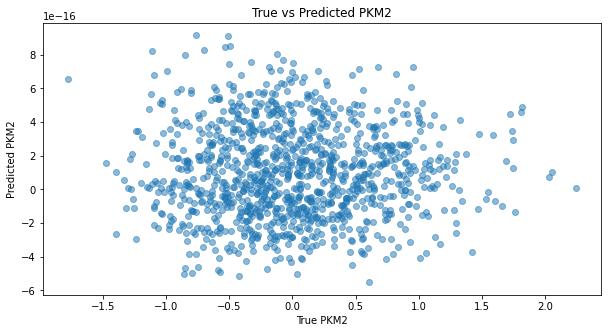

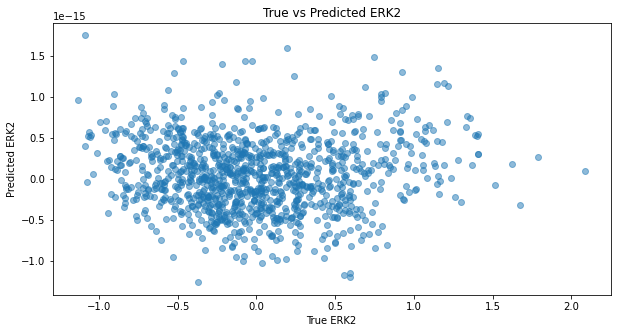

In [24]:
# Plotting true vs predicted for PKM2
plt.figure(figsize=(10, 5))
plt.scatter(y_pkm2_tested, y_pkm2_pred_tested, alpha=0.5)
plt.xlabel('True PKM2')
plt.ylabel('Predicted PKM2')
plt.title('True vs Predicted PKM2')
plt.show()

# Plotting true vs predicted for ERK2
plt.figure(figsize=(10, 5))
plt.scatter(y_erk2_tested, y_erk2_pred_tested, alpha=0.5)
plt.xlabel('True ERK2')
plt.ylabel('Predicted ERK2')
plt.title('True vs Predicted ERK2')
plt.show()